In [1]:
import torch, torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import time
from torchvision.models import efficientnet_b0
#from torchsummary import summary

import numpy as np
import matplotlib.pyplot as plt
import os

from PIL import Image

In [2]:
image_transforms = { 
    'train': transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

In [3]:
dir="C:\Survallaince_Project"
dir

'C:\\Survallaince_Project'

In [4]:
# Load the Data

# Set train and valid directory paths

dataset = "C:\Survallaince_Project"

train_directory = os.path.join(dataset, 'train')
valid_directory = os.path.join(dataset, 'valid')

# Batch size
bs = 32

# Number of classes
num_classes = len(os.listdir(valid_directory))  
print(num_classes)

# Load Data from folders
data = {
    'train': datasets.ImageFolder(root=train_directory, transform=image_transforms['train']),
    'valid': datasets.ImageFolder(root=valid_directory, transform=image_transforms['valid'])
}

# Get a mapping of the indices to the class names, in order to see the output classes of the test images.
idx_to_class = {v: k for k, v in data['train'].class_to_idx.items()}
print(idx_to_class)

# Size of Data, to be used for calculating Average Loss and Accuracy
train_data_size = len(data['train'])
valid_data_size = len(data['valid'])

# Create iterators for the Data loaded using DataLoader module
train_data_loader = DataLoader(data['train'], batch_size=bs, shuffle=True)
valid_data_loader = DataLoader(data['valid'], batch_size=bs, shuffle=True)

2
{0: 'fire', 1: 'human'}


In [5]:
train_data_size, valid_data_size

(1282, 1305)

In [6]:
alexnet = models.alexnet(pretrained=True)
alexnet

C:\Users\ksjav\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\ksjav\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [7]:
for param in alexnet.parameters():
    param.requires_grad = False

In [8]:
alexnet.classifier[6] = nn.Linear(4096, num_classes)
alexnet.classifier.add_module("7", nn.LogSoftmax(dim = 1))
alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [9]:
# Define Optimizer and Loss Function
loss_func = nn.NLLLoss()
optimizer = optim.Adam(alexnet.parameters())
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

In [10]:
import cv2  # still used to save images out
import os
import numpy as np
from decord import VideoReader
from decord import cpu, gpu
import time

def extract_frames(video_path, frames_dir, overwrite=False, start=-1, end=-1, every=1):
    """
    Extract frames from a video using decord's VideoReader
    :param video_path: path of the video
    :param frames_dir: the directory to save the frames
    :param overwrite: to overwrite frames that already exist?
    :param start: start frame
    :param end: end frame
    :param every: frame spacing
    :return: count of images saved
    """
    video_path = os.path.normpath(video_path)  # make the paths OS (Windows) compatible
    frames_dir = os.path.normpath(frames_dir)  # make the paths OS (Windows) compatible

    video_dir, video_filename = os.path.split(video_path)  # get the video path and filename from the path

    assert os.path.exists(video_path)  # assert the video file exists

    # load the VideoReader
    vr = VideoReader(video_path, ctx=cpu(0))  # can set to cpu or gpu .. ctx=gpu(0)
                     
    if start < 0:  # if start isn't specified lets assume 0
        start = 0
    if end < 0:  # if end isn't specified assume the end of the video
        end = len(vr)

    frames_list = list(range(start, end, every))
    saved_count = 0

    if every > 25 and len(frames_list) < 1000:  # this is faster for every > 25 frames and can fit in memory
        frames = vr.get_batch(frames_list).asnumpy()

        for index, frame in zip(frames_list, frames):  # lets loop through the frames until the end
            save_path = os.path.join(frames_dir, video_filename, "{:010d}.jpg".format(index))  # create the save path
            if not os.path.exists(save_path) or overwrite:  # if it doesn't exist or we want to overwrite anyways
                cv2.imwrite(save_path, cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))  # save the extracted image
                saved_count += 1  # increment our counter by one

    else:  # this is faster for every <25 and consumes small memory
        for index in range(start, end):  # lets loop through the frames until the end
            frame = vr[index]  # read an image from the capture
            
            if index % every == 0:  # if this is a frame we want to write out based on the 'every' argument
                save_path = os.path.join(frames_dir, video_filename, "{:010d}.jpg".format(index))  # create the save path
                if not os.path.exists(save_path) or overwrite:  # if it doesn't exist or we want to overwrite anyways
                    cv2.imwrite(save_path, cv2.cvtColor(frame.asnumpy(), cv2.COLOR_RGB2BGR))  # save the extracted image
                    saved_count += 1  # increment our counter by one

    return saved_count  # and return the count of the images we saved


def video_to_frames(video_path, frames_dir, overwrite=False, every=1):
    """
    Extracts the frames from a video
    :param video_path: path to the video
    :param frames_dir: directory to save the frames
    :param overwrite: overwrite frames if they exist?
    :param every: extract every this many frames
    :return: path to the directory where the frames were saved, or None if fails
    """
    start_time = time.time()
    video_path = os.path.normpath(video_path)  # make the paths OS (Windows) compatible
    frames_dir = os.path.normpath(frames_dir)  # make the paths OS (Windows) compatible

    video_dir, video_filename = os.path.split(video_path)  # get the video path and filename from the path


    # Make directory to save frames, it's a sub dir in the frames_dir with the video name
    os.makedirs(os.path.join(frames_dir,video_filename), exist_ok=True)
    
    print("Extracting frames from {}".format(video_filename))
    
    extract_frames(video_path, frames_dir, every=every)  # let's now extract the frames
    print((time.time() - start_time))
    return os.path.join(frames_dir, video_filename)
    

In [11]:
import os
import glob

# Assuming 'videos' is the folder path containing the video files
videos_folder = "C:\\Survallaince_Project\\videos"

# Get a list of all video files in the 'videos' folder
videos = [os.path.splitext(os.path.basename(file))[0] for file in glob.glob(os.path.join(videos_folder, '*.mp4'))]

# Iterate over each filename in the 'videos' list
for filename in videos:
    # Extract frames from the video
    video_to_frames(video_path=f'C:\\Survallaince_Project\\videos\\{filename}.mp4', frames_dir="C:\\Survallaince_Project\\test_frames", overwrite=False, every=310)

    # Construct current and new folder names
    current_folder_name = f"C:\\Survallaince_Project\\test_frames\\{filename}.mp4"
    new_folder_name = f"C:\\Survallaince_Project\\test_frames\\{filename}"

    # Rename the folder
    os.rename(current_folder_name, new_folder_name)


Extracting frames from fire_v1.mp4
0.06627154350280762
Extracting frames from v2.mp4
0.18650102615356445
Extracting frames from v3.mp4
3.0504560470581055
Extracting frames from v4.mp4
0.3422815799713135


In [12]:
def train_and_validate(model, loss_criterion, optimizer, epochs=5):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)
  
    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''
    
    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        # Set to training mode
        model.train()
        
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for i, (inputs, labels) in enumerate(train_data_loader):

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Clean existing gradients
            optimizer.zero_grad()
            
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            
            # Compute loss
            loss = loss_criterion(outputs, labels)
            
            # Backpropagate the gradients
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            
            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)
            
            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

            
        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(valid_data_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
            
        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size 
        avg_train_acc = train_acc/train_data_size

        # Find average training loss and training accuracy
        avg_valid_loss = valid_loss/valid_data_size 
        avg_valid_acc = valid_acc/valid_data_size

        history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])
                
        epoch_end = time.time()
    
        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch+1, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_end-epoch_start))
        
        # Save if the model has best accuracy till now
        #torch.save(model, dataset+'model'+str(epoch)+'.pt')
            
    return model, history

In [14]:
import os
os.makedirs(dataset, exist_ok=True)

# Save the training history

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

num_epochs = 1
trained_model, history = train_and_validate(alexnet, loss_func, optimizer, num_epochs)

torch.save(history, os.path.join(dataset, '_history.pt'))

Epoch: 1/1
Epoch : 001, Training: Loss: 0.0072, Accuracy: 99.6100%, 
		Validation : Loss : 0.0060, Accuracy: 99.8467%, Time: 98.6194s


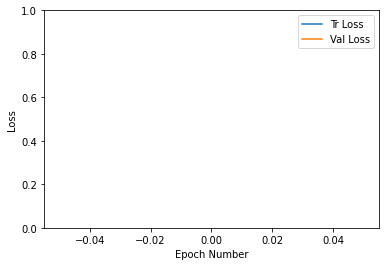

In [15]:
history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,1)
plt.show()

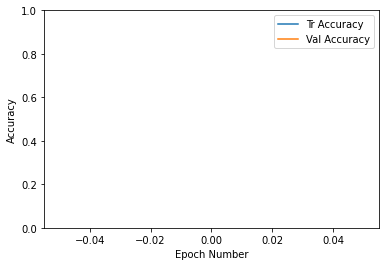

In [16]:
plt.plot(history[:,2:4])
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.show()

In [17]:
def predict(model, test_image_name):
    '''
    Function to predict the class of a single test image
    Parameters
        :param model: Model to test
        :param test_image_name: Test image

    '''
    
    transform = image_transforms['test']

    test_image = Image.open(test_image_name)
    plt.imshow(test_image)
    
    test_image_tensor = transform(test_image)

    if torch.cuda.is_available():
        test_image_tensor = test_image_tensor.view(1, 3, 224, 224).cuda()
    else:
        test_image_tensor = test_image_tensor.view(1, 3, 224, 224)
    
    with torch.no_grad():
        model.eval()
        # Model outputs log probabilities
        out = model(test_image_tensor)
        ps = torch.exp(out)
        topk, topclass = ps.topk(2, dim=1)
        for i in range(2):
            print("Predcition", i+1, ":", idx_to_class[topclass.numpy()[0][i]], ", Score: ", topk.numpy()[0][i])

Predcition 1 : fire , Score:  0.99999607
Predcition 2 : human , Score:  3.967043e-06


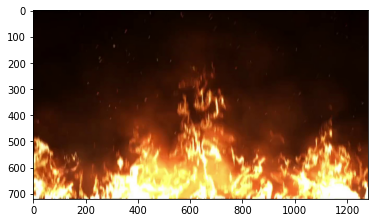

In [18]:
predict(trained_model,"C:\\Survallaince_Project\\test_frames\\fire_v1\\0000000000.jpg")

Predictions for frames in fire_v1:
Frame 0.0
Predcition 1 : fire , Score:  0.99999607
Predcition 2 : human , Score:  3.967043e-06
Predictions for frames in v2:
Frame 0.0
Predcition 1 : human , Score:  0.9938822
Predcition 2 : fire , Score:  0.0061178165
Frame 1.0
Predcition 1 : human , Score:  0.8485049
Predcition 2 : fire , Score:  0.15149505
Predictions for frames in v3:
Frame 0.0
Predcition 1 : fire , Score:  0.98701584
Predcition 2 : human , Score:  0.012984135
Frame 1.0
Predcition 1 : fire , Score:  0.85719043
Predcition 2 : human , Score:  0.1428096
Frame 2.0
Predcition 1 : fire , Score:  0.9960975
Predcition 2 : human , Score:  0.0039024688
Frame 3.0
Predcition 1 : fire , Score:  0.8712316
Predcition 2 : human , Score:  0.12876846
Frame 4.0
Predcition 1 : fire , Score:  0.8712316
Predcition 2 : human , Score:  0.12876846
Frame 5.0
Predcition 1 : fire , Score:  0.8712316
Predcition 2 : human , Score:  0.12876846
Frame 6.0
Predcition 1 : fire , Score:  0.8712316
Predcition 2 : hum

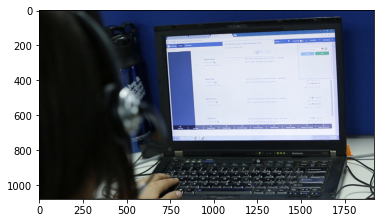

In [20]:
test_frames_dir = "C:\\Survallaince_Project\\test_frames"

# Loop through each subfolder in test_frames
for subdir in os.listdir(test_frames_dir):
    subdir_path = os.path.join(test_frames_dir, subdir)
    if os.path.isdir(subdir_path):
        print(f"Predictions for frames in {subdir}:")
        # Loop through each frame inside the subfolder
        for frame_file in os.listdir(subdir_path):
            if frame_file.endswith('.jpg'):
                frame_path = os.path.join(subdir_path, frame_file)
                frame_number = int(frame_file.split('.')[0])/310
                print(f"Frame {frame_number}");
                predict(trained_model, frame_path)